The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [ ]:
!pip install d2l==0.17.1


# Análise de Sentimento: Usando Redes Neurais Convolucionais
:label:`sec_sentiment_cnn`

Em :numref:`chap_cnn`, exploramos como processar dados de imagens bidimensionais com redes neurais convolucionais bidimensionais. Nos modelos de linguagem anteriores e nas tarefas de classificação de texto, tratamos os dados de texto como uma série temporal com apenas uma dimensão e, naturalmente, usamos redes neurais recorrentes para processar esses dados. Na verdade, também podemos tratar
texto como uma imagem unidimensional, para que possamos usar redes neurais convolucionais unidimensionais para capturar associações entre palavras adjacentes.
Conforme descrito em :numref:`fig_nlp-map-sa-cnn`
Esta seção descreve uma abordagem inovadora para aplicar
Redes neurais convolucionais para análise de sentimento: textCNN :cite:`Kim.2014`.

![Esta seção alimenta o GloVe pré-treinado para uma arquitetura baseada em CNN para análise de sentimento.](../img/nlp-map-sa-cnn.svg)
:label:`fig_nlp-map-sa-cnn`

Primeiro, importe os pacotes e módulos necessários para o experimento.


In [1]:
import torch
from torch import nn
from d2l import torch as d2l

batch_size = 64
train_iter, test_iter, vocab = d2l.load_data_imdb(batch_size)

## Camada Convolucional Unidimensional

Antes de apresentar o modelo, vamos explicar como funciona uma camada convolucional unidimensional. Como uma camada convolucional bidimensional, uma camada convolucional unidimensional usa uma operação de correlação cruzada unidimensional. Na operação de correlação cruzada unidimensional, a janela de convolução começa do lado esquerdo da matriz de entrada e desliza na matriz de entrada da esquerda para a direita sucessivamente. Quando a janela de convolução desliza para uma determinada posição, o subarray de entrada na janela e o array kernel são multiplicados e somados por elemento para obter o elemento no local correspondente no array de saída. Conforme mostrado em :numref:`fig_conv1d`, a entrada é uma matriz unidimensional com largura 7 e a largura da matriz do kernel é 2. Como podemos ver, a largura de saída é $7-2+1=6$ e o primeiro elemento é obtido executando a multiplicação por elemento no submatriz de entrada mais à esquerda com uma largura de 2 e o array *kernel* e, em seguida, somando os resultados.

![Operação de correlação cruzada unidimensional. As partes sombreadas são o primeiro elemento de saída, bem como os elementos de matriz de entrada e *kernel* usados em seu cálculo: $0\times1+1\times2=2$. ](http://d2l.ai/_images/conv1d.svg)
:label:`fig_conv1d`

Em seguida, implementamos a correlação cruzada unidimensional na função `corr1d`. Ele aceita a matriz de entrada `X` e a matriz de *kernel* `K` e produz a matriz `Y`.


In [2]:
def corr1d(X, K):
    w = K.shape[0]
    Y = torch.zeros((X.shape[0] - w + 1))
    for i in range(Y.shape[0]):
        Y[i] = (X[i: i + w] * K).sum()
    return Y

Agora, iremos reproduzir os resultados da operação de correlação cruzada unidimensional em :numref:`fig_conv1d`.


In [3]:
X, K = torch.tensor([0, 1, 2, 3, 4, 5, 6]), torch.tensor([1, 2])
corr1d(X, K)

tensor([ 2.,  5.,  8., 11., 14., 17.])

A operação de correlação cruzada unidimensional para vários canais de entrada também é semelhante à operação de correlação cruzada bidimensional para vários canais de entrada. Em cada canal, ela executa a operação de correlação cruzada unidimensional no *kernel* e sua entrada correspondente e adiciona os resultados dos canais para obter a saída. :numref:`fig_conv1d_channel` mostra uma operação de correlação cruzada unidimensional com três canais de entrada.

![Operação de correlação cruzada unidimensional com três canais de entrada. As partes sombreadas são o primeiro elemento de saída, bem como os elementos da matriz de entrada e *kernel* usados em seu cálculo: $0\times1+1\times2+1\times3+2\times4+2\times(-1)+3\times(-3)=2$. ](../img/conv1d-channel.svg)
:label:`fig_conv1d_channel`

Agora, reproduzimos os resultados da operação de correlação cruzada unidimensional com o canal de entrada múltipla em :numref:`fig_conv1d_channel`.


In [4]:
def corr1d_multi_in(X, K):
    # First, we traverse along the 0th dimension (channel dimension) of `X`
    # and `K`. Then, we add them together by using * to turn the result list
    # into a positional argument of the `add_n` function
    return sum(corr1d(x, k) for x, k in zip(X, K))

X = torch.tensor([[0, 1, 2, 3, 4, 5, 6],
              [1, 2, 3, 4, 5, 6, 7],
              [2, 3, 4, 5, 6, 7, 8]])
K = torch.tensor([[1, 2], [3, 4], [-1, -3]])
corr1d_multi_in(X, K)

tensor([ 2.,  8., 14., 20., 26., 32.])

A definição de uma operação de correlação cruzada bidimensional nos diz que uma operação de correlação cruzada unidimensional com múltiplos canais de entrada pode ser considerada como uma operação de correlação cruzada bidimensional com um único canal de entrada. Conforme mostrado em :numref:`fig_conv1d_2d`, também podemos apresentar a operação de correlação cruzada unidimensional com múltiplos canais de entrada em :numref:`fig_conv1d_channel` como a operação de correlação cruzada bidimensional equivalente com um único canal de entrada. Aqui, a altura do *kernel* é igual à altura da entrada.

![Operação de correlação cruzada bidimensional com um único canal de entrada. As partes destacadas são o primeiro elemento de saída e os elementos de matriz de entrada e *kernel* usados em seu cálculo: $2\times(-1)+3\times(-3)+1\times3+2\times4+0\times1+1\times2=2$. ](../img/conv1d-2d.svg)
:label:`fig_conv1d_2d`

Ambas as saídas em :numref:`fig_conv1d` e :numref:`fig_conv1d_channel` têm apenas um canal. Nós
discutimos como especificar múltiplos canais de saída em uma camada convolucional bidimensional em :numref:`sec_channels`.
Da mesma forma, também podemos especificar vários canais de saída na camada convolucional unidimensional para estender os parâmetros do modelo na camada convolucional.


## Camada de Pooling Máximo ao Longo do Tempo

Da mesma forma, temos uma camada de *pooling* unidimensional. A camada de *pooling* máximo ao longo do tempo usada no TextCNN na verdade corresponde a uma camada de *pooling* global unidimensional máxima. Assumindo que a entrada contém vários canais, e cada canal consiste em valores em intervalos de tempo diferentes, a saída de cada canal será o maior valor de todos os intervalos de tempo no canal. Portanto, a entrada da camada de *pooling* max-over-time pode ter diferentes intervalos de tempo em cada canal.

Para melhorar o desempenho da computação, geralmente combinamos exemplos de tempo de diferentes comprimentos em um minibatch e tornamos os comprimentos de cada exemplo de tempo no lote consistentes, acrescentando caracteres especiais (como 0) ao final dos exemplos mais curtos. Naturalmente, os caracteres especiais adicionados não têm significado intrínseco. Como o objetivo principal da camada de *pooling max-over-time* é capturar os recursos mais importantes de temporização, ela geralmente permite que o modelo não seja afetado pelos caracteres adicionados manualmente.

## O Modelo TextCNN

O TextCNN usa principalmente uma camada convolucional unidimensional e uma camada de *pooling* máximo ao longo do tempo. Suponha que a sequência de texto de entrada consista em $n$ palavras e cada palavra seja representada por um vetor de palavra de dimensão $d$. Então, o exemplo de entrada tem uma largura de $n$, uma altura de 1 e $d$ canais de entrada. O cálculo de textCNN pode ser dividido principalmente nas seguintes etapas:

1. Definindo vários *kernels* de convolução unidimensionais e usando-os para realizar cálculos de convolução nas entradas. Os núcleos de convolução com larguras diferentes podem capturar a correlação de diferentes números de palavras adjacentes.
2. Executando o *pooling* máximo ao longo do tempo em todos os canais de saída e, a seguir, concatene os valores de saída do *pooling* desses canais em um vetor.
3. O vetor concatenado é transformado na saída de cada categoria por meio da camada totalmente conectada. Uma camada de eliminação pode ser usada nesta etapa para lidar com o *overfitting*.

![Design de TextCNN.](http://d2l.ai/_images/textcnn.svg)
:label:`fig_conv1d_textcnn`

:numref:`fig_conv1d_textcnn` dá um exemplo para ilustrar o textCNN. A entrada aqui é uma frase com 11 palavras, com cada palavra representada por um vetor de palavra de 6 dimensões. Portanto, a sequência de entrada tem uma largura de 11 e 6 canais de entrada. Assumimos que há dois núcleos de convolução unidimensionais com larguras de 2 e 4, e 4 e 5 canais de saída, respectivamente. Portanto, após o cálculo da convolução unidimensional, a largura dos quatro canais de saída é $11-2+1=10$, enquanto a largura dos outros cinco canais é $11-4+1=8$. Mesmo que a largura de cada canal seja diferente, ainda podemos executar o *pooling* máximo ao longo do tempo para cada canal e concatenar as saídas do pooling dos 9 canais em um vetor de 9 dimensões. Finalmente, usamos uma camada totalmente conectada para transformar o vetor 9-dimensional em uma saída bidimensional: previsões de sentimento positivo e sentimento negativo.

A seguir, implementaremos um modelo textCNN. Em comparação com a seção anterior, além de substituir a rede neural recorrente por uma camada convolucional unidimensional, aqui usamos duas camadas de incorporação, uma com peso fixo e outra que participa do treinamento.


In [5]:
class TextCNN(nn.Module):
    def __init__(self, vocab_size, embed_size, kernel_sizes, num_channels,
                 **kwargs):
        super(TextCNN, self).__init__(**kwargs)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        # The embedding layer does not participate in training
        self.constant_embedding = nn.Embedding(vocab_size, embed_size)
        self.dropout = nn.Dropout(0.5)
        self.decoder = nn.Linear(sum(num_channels), 2)
        # The max-over-time pooling layer has no weight, so it can share an
        # instance
        self.pool = nn.AdaptiveAvgPool1d(1)
        self.relu = nn.ReLU()
        # Create multiple one-dimensional convolutional layers
        self.convs = nn.ModuleList()
        for c, k in zip(num_channels, kernel_sizes):
            self.convs.append(nn.Conv1d(2 * embed_size, c, k))

    def forward(self, inputs):
        # Concatenate the output of two embedding layers with shape of
        # (batch size, no. of words, word vector dimension) by word vector
        embeddings = torch.cat((
            self.embedding(inputs), self.constant_embedding(inputs)), dim=2)
        # According to the input format required by Conv1d, the word vector
        # dimension, that is, the channel dimension of the one-dimensional
        # convolutional layer, is transformed into the previous dimension
        embeddings = embeddings.permute(0, 2, 1)
        # For each one-dimensional convolutional layer, after max-over-time
        # pooling, a tensor with the shape of (batch size, channel size, 1)
        # can be obtained. Use the flatten function to remove the last
        # dimension and then concatenate on the channel dimension
        encoding = torch.cat([
            torch.squeeze(self.relu(self.pool(conv(embeddings))), dim=-1)
            for conv in self.convs], dim=1)
        # After applying the dropout method, use a fully connected layer to
        # obtain the output
        outputs = self.decoder(self.dropout(encoding))
        return outputs

Criando uma instância TextCNN. Possui 3 camadas convolucionais com larguras de *kernel* de 3, 4 e 5, todas com 100 canais de saída.


In [6]:
embed_size, kernel_sizes, nums_channels = 100, [3, 4, 5], [100, 100, 100]
devices = d2l.try_all_gpus()
net = TextCNN(len(vocab), embed_size, kernel_sizes, nums_channels)

def init_weights(m):
    if type(m) in (nn.Linear, nn.Conv1d):
        nn.init.xavier_uniform_(m.weight)

net.apply(init_weights);

### Carregando Vetores de Palavras Pré-treinados

Como na seção anterior, carregamos os vetores de palavras GloVe 100-dimensionais pré-treinados e inicializamos as camadas de incorporação `embedding` e `constant_embedding`. Aqui, o primeiro participa do treinamento, enquanto o segundo tem peso fixo.


In [7]:
glove_embedding = d2l.TokenEmbedding('glove.6b.100d')
embeds = glove_embedding[vocab.idx_to_token]
net.embedding.weight.data.copy_(embeds)
net.constant_embedding.weight.data.copy_(embeds)
net.constant_embedding.weight.requires_grad = False

### Treinamento e Avaliação do Modelo

Agora podemos treinar o modelo.


loss 0.069, train acc 0.978, test acc 0.874
2703.4 examples/sec on [device(type='cuda', index=0), device(type='cuda', index=1)]


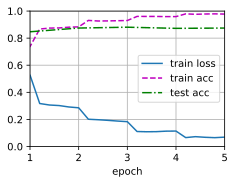

In [8]:
lr, num_epochs = 0.001, 5
trainer = torch.optim.Adam(net.parameters(), lr=lr)
loss = nn.CrossEntropyLoss(reduction="none")
d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs, devices)

A seguir, usamos o modelo treinado para classificar os sentimentos de duas frases simples.


In [9]:
d2l.predict_sentiment(net, vocab, 'this movie is so great')

'positive'

In [10]:
d2l.predict_sentiment(net, vocab, 'this movie is so bad')

'negative'

## Resumo

* Podemos usar convolução unidimensional para processar e analisar dados de tempo.
* Uma operação de correlação cruzada unidimensional com múltiplos canais de entrada pode ser considerada como uma operação de correlação cruzada bidimensional com um único canal de entrada.
* A entrada da camada de *pooling* máximo ao longo do tempo pode ter diferentes números de etapas de tempo em cada canal.
* TextCNN usa principalmente uma camada convolucional unidimensional e uma camada de *pooling* máximo ao longo do tempo.


## Exercícios

1. Ajuste os hiperparâmetros e compare os dois métodos de análise de sentimento, usando redes neurais recorrentes e usando redes neurais convolucionais, no que diz respeito à precisão e eficiência operacional.
1. Você pode melhorar ainda mais a precisão do modelo no conjunto de teste usando os três métodos apresentados na seção anterior: ajuste de hiperparâmetros, uso de vetores de palavras pré-treinados maiores e uso da ferramenta de tokenização de palavras spaCy?
1. Para quais outras tarefas de processamento de linguagem natural você pode usar o textCNN?
1. Adicione codificação posicional nas representações de entrada. Isso melhora o desempenho?


[Discussões](https://discuss.d2l.ai/t/1425)


<!--stackedit_data:
eyJoaXN0b3J5IjpbLTIwNTMxMzc5NjIsLTIwNDI5ODAzNzcsLT
M1Mzk1Mjc2MywtMTIxMTU0MDU2MSwtMjg3MTc5OTc2LDU4MzY0
MjQzN119
-->
